In [1]:
# Import the libraries
import tweepy
import configparser
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import requests
import os
import json
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
# read configs
config = configparser.ConfigParser()
config.read('config.ini')

api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']

access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

api_key

'B6mzf9ArWlSiMb4KIwiPI5jMz'

In [3]:
#authentication
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token,access_token_secret)

api = tweepy.API(auth,wait_on_rate_limit=True)

In [4]:
place_id = '6416b8512febefc9'
geocode = '54.00366, -2.547855, 380mi'

In [5]:
api.search_geo(query='united kingdom', granularity='country')[2]

Place(_api=<tweepy.api.API object at 0x000001B1BF841BB0>, id='6416b8512febefc9', name='United Kingdom', full_name='United Kingdom', country='United Kingdom', country_code='GB', url='https://api.twitter.com/1.1/geo/id/6416b8512febefc9.json', place_type='country', attributes={}, bounding_box=BoundingBox(_api=<tweepy.api.API object at 0x000001B1BF841BB0>, type='Polygon', coordinates=[[[-8.662663, 49.1626564], [-8.662663, 60.86165], [1.768926, 60.86165], [1.768926, 49.1626564], [-8.662663, 49.1626564]]]), centroid=[-1.9280961449649903, 54.3306728], contained_within=[])

In [ ]:
#user tweets
keywords = 'Morrisons -filter:retweets' #place:%s' % place_id
limit = 10000

tweets = tweepy.Cursor(api.search_tweets, lang='en', q=keywords, 
                       count=limit, 
                       #geocode = '51.509865, -0.118092, 250mi',
                       tweet_mode='extended').items(limit)
columns = ['Time', 'User','Location', 'Tweet', 'Favourites_count','retweet_count']
data = []
for tweet in tweets:
    data.append([tweet.created_at, tweet.user.screen_name, tweet.user.location, tweet.full_text, tweet.user.favourites_count,tweet.retweet_count])

df = pd.DataFrame(data, columns=columns)
df

Rate limit reached. Sleeping for: 610


In [105]:
df.to_csv('tweets.csv')

In [6]:
bearer_token='AAAAAAAAAAAAAAAAAAAAALrlfAEAAAAAO4fxHz7WtSSp4YoTSXIVjE94uTI%3Dz8qZV7q3iriCdmkpLOAM7YM0wdvX2Tdrf1g9kSQoI4azB234FD'

In [93]:
client = tweepy.Client( bearer_token=bearer_token, 
                        consumer_key=api_key, 
                        consumer_secret=api_key_secret, 
                        access_token=access_token, 
                        access_token_secret=access_token_secret, 
                        return_type = requests.Response,
                        wait_on_rate_limit=True)

hoax_tweets = []
query = 'aldi lang:en -is:retweet'

# Replace the limit=1000 with the maximum number of Tweets you want
for response in tweepy.Paginator(client.search_recent_tweets, query=query,
                              user_fields = ['username', 'public_metrics', 'description', 'location'],
                              tweet_fields = ['author_id','created_at','text','source', 'public_metrics','geo'],
                              expansions = ['geo.place_id', 'author_id'],
                              place_fields = ['country','country_code'],
                              max_results = 100,
                              ):
    hoax_tweets.append(response)
    
result = []
user_dict = {}
media_dict = {}


# Loop through each response object
for response in hoax_tweets:
    # Take all of the users, and put them into a dictionary of dictionaries with the info we want to keep
    for user in response.includes['users']:
        user_dict[user.id] = {'username': user.username, 
                              'followers': user.public_metrics['followers_count'],
                              'tweets': user.public_metrics['tweet_count'],
                              'description': user.description,
                              'location': user.location,
                              'verified': user.verified
                             }

    for tweet in response.data:
        # For each tweet, find the author's information
        author_info = user_dict[tweet.author_id]
        # Put all of the information we want to keep in a single dictionary for each tweet
        result.append({'author_id': tweet.author_id, 
                       'username': author_info['username'],
                       'author_followers': author_info['followers'],
                       'author_tweets': author_info['tweets'],
                       'author_description': author_info['description'],
                       'author_location': author_info['location'],
                       'author_verified':author_info['verified'],
                       'tweet_id': tweet.id,
                       'text': tweet.text,
                       'created_at': tweet.created_at,
                       'retweets': tweet.public_metrics['retweet_count'],
                       'replies': tweet.public_metrics['reply_count'],
                       'likes': tweet.public_metrics['like_count'],
                       'quote_count': tweet.public_metrics['quote_count'],
                       'in_reply_to_user_id':tweet.in_reply_to_user_id,
                       'conversation':tweet.referenced_tweets
                      })
df2 = pd.DataFrame(result)

AttributeError: 'Response' object has no attribute 'meta'

In [185]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

# Creating list to append tweet data to
attributes_container = []
loc = '54.00366, -2.547855, 500mi'

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('Morrisons since:2019-05-01 until:2019-08-01 lang:en geocode:"{}"'.format(loc)).get_items()):
    if i>10999:
        break
    attributes_container.append([tweet.user.username, tweet.date, tweet.likeCount, tweet.user.location, tweet.content,tweet.retweetCount])
    
# Creating a dataframe to load the list
tweets_df = pd.DataFrame(attributes_container, columns=["User", "Date Created", "Number of Likes", "Location", "Tweet", "retweet_count"])

In [186]:
tweets_df['Date Created']

0      2019-07-31 21:18:19+00:00
1      2019-07-31 21:15:43+00:00
2      2019-07-31 20:24:04+00:00
3      2019-07-31 19:55:39+00:00
4      2019-07-31 19:47:33+00:00
                  ...           
4488   2019-05-01 09:57:00+00:00
4489   2019-05-01 08:33:53+00:00
4490   2019-05-01 08:24:34+00:00
4491   2019-05-01 08:21:12+00:00
4492   2019-05-01 06:57:09+00:00
Name: Date Created, Length: 4493, dtype: datetime64[ns, UTC]

In [188]:
tweets_df.to_csv('mor 190501 190801.csv')

# Analysis

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
plt.style.use('ggplot')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import Word, TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
sid= SentimentIntensityAnalyzer()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')
stop_words = stopwords.words('english')
custom_stopwords = ('RT', '#aldi','one','get','got','amp','im','ive','ill','aldi_ireland','aldi','aldiuk')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Aldi

In [110]:
df = pd.read_csv('aldi 180101 180701.csv')
print(df.shape)
df=df.iloc[:,1:]

(10673, 7)


In [88]:
df = pd.read_csv('aldi 180701 181231.csv')
print(df.shape)
df=df.iloc[:,1:]

(12775, 7)


In [118]:
df = pd.read_csv('aldi 190101 190701.csv')
print(df.shape)
df=df.iloc[:,1:]

(8505, 7)


In [248]:
df = pd.read_csv('aldi 181101 190201.csv')
print(df.shape)
df=df.iloc[:,1:]

(7075, 7)


In [69]:
df = pd.read_csv('aldi 19.csv')
print(df.shape)
df=df.iloc[:,1:]

(17158, 7)


In [4]:
df.head()

User               Date Created  Number of Likes  \
0         gemc200  2018-06-30 22:48:00+00:00                1   
1    ZoeAshbridge  2018-06-30 22:19:46+00:00                1   
2   ruth_pickford  2018-06-30 21:17:02+00:00                0   
3   robingill1984  2018-06-30 21:16:14+00:00                1   
4  Black_Crab_MCR  2018-06-30 21:15:27+00:00                1   

              Location                                              Tweet  \
0    Glasgow, Scotland  @AldiUK Your veggie sushi was delicious, as a ...   
1  Highlands, Scotland  #JOGLE 🏴󠁧󠁢󠁳󠁣󠁴󠁿🚴🏻‍♂️🚴🏻‍♀️🏴󠁧󠁢󠁥󠁮󠁧󠁿 Day 2 : \n\nTh...   
2  North West, England  @AldiUK @baberooo please shop at Aldi and save...   
3                  NaN  It was too hot to cook so a bottle of @AldiUK ...   
4                  NaN  @Out_About_Mummy @AldiUK Ah nevermind! Was a l...   

   retweet_count  
0              0  
1              1  
2              0  
3              0  
4              0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23448 entries, 0 to 23447
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User             23448 non-null  object
 1   Date Created     23448 non-null  object
 2   Number of Likes  23448 non-null  int64 
 3   Location         20236 non-null  object
 4   Tweet            23448 non-null  object
 5   retweet_count    23448 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


In [6]:
def preprocess_tweets(tweet, custom_stopwords):
    processed_tweet = tweet
    #processed_tweet.replace('[^\w\s]', '')
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in stop_words)
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in custom_stopwords)
    processed_tweet = " ".join(Word(word).lemmatize() for word in processed_tweet.split())
    return(processed_tweet)

In [7]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r'\@[^\s]+','',text)
    text = re.sub('@[^\s]+','',text)
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data


In [8]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def sentiment(label):
    if label>0:
        return "Positive"
    elif label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    


In [70]:
df['text'] = df['Tweet'].apply(lambda x: preprocess_tweets(x, custom_stopwords))
df.head()

User               Date Created  Number of Likes  \
0   telescoper  2019-06-30 21:42:15+00:00                0   
1   tinselgirl  2019-06-30 21:31:14+00:00                0   
2   JongaConga  2019-06-30 19:38:27+00:00                1   
3    Fio_namac  2019-06-30 18:55:42+00:00                0   
4  samladflynn  2019-06-30 18:06:41+00:00                1   

                        Location  \
0  Maynooth, Co Kildare, Ireland   
1                            NaN   
2                          Leeds   
3              Galston, Scotland   
4          Huddersfield, England   

                                               Tweet  retweet_count  \
0  @garwboy You often find aerosols in the car pa...              0   
1  @AldiUK how useful thank you. hope it's not mu...              0   
2  @lottyburns Gonna use a 99p BIC razor from Ald...              0   
3      @AldiUK I’d be delighted thank you 🤞@emmajw11              0   
4  Tried Lidl out for the first time and can hone...              0   

                                                text  
0     @garwboy You often find aerosol car park Aldi.  
1              @AldiUK useful thank you. hope muddy.  
2  @lottyburns Gonna use 99p BIC razor Aldi co I ...  
3             @AldiUK I’d delighted thank 🤞@emmajw11  
4  Tried Lidl first time honestly say nothing com...

In [71]:
df['Date'] = pd.to_datetime(df['Date Created'])
df['Month'] = df['Date'].dt.month

text_df=df.drop(['User','Date Created','Number of Likes','Location','Tweet','retweet_count'], axis=1)

In [72]:
df.loc[:,'text'] = df['text'].apply(data_processing)
df = df.drop_duplicates('text')

df.loc[:,'text'] = df['text'].apply(lambda x: stemming(x))

df.head(10)

User               Date Created  Number of Likes  \
0       telescoper  2019-06-30 21:42:15+00:00                0   
1       tinselgirl  2019-06-30 21:31:14+00:00                0   
2       JongaConga  2019-06-30 19:38:27+00:00                1   
3        Fio_namac  2019-06-30 18:55:42+00:00                0   
4      samladflynn  2019-06-30 18:06:41+00:00                1   
5  realalefanvince  2019-06-30 17:47:05+00:00                0   
6   SaraMacGregor8  2019-06-30 17:46:47+00:00                3   
7     The_Mason_85  2019-06-30 17:44:40+00:00                1   
8          antsuxx  2019-06-30 17:14:19+00:00                1   
9         jruddy99  2019-06-30 17:01:51+00:00                0   

                        Location  \
0  Maynooth, Co Kildare, Ireland   
1                            NaN   
2                          Leeds   
3              Galston, Scotland   
4          Huddersfield, England   
5         East Midlands, England   
6            Chichester, England   
7              Baile Átha Cliath   
8            West Sussex,England   
9             Montrose, Scotland   

                                               Tweet  retweet_count  \
0  @garwboy You often find aerosols in the car pa...              0   
1  @AldiUK how useful thank you. hope it's not mu...              0   
2  @lottyburns Gonna use a 99p BIC razor from Ald...              0   
3      @AldiUK I’d be delighted thank you 🤞@emmajw11              0   
4  Tried Lidl out for the first time and can hone...              0   
5  Drinking a Church's Ginger Beer by @AldiUK @ v...              0   
6  Just watched my kids run through the silver se...              0   
7  @bohsmark Didn't have the food we wanted so we...              0   
8  @PeterHaskew @Z_Energy @MikeH_PR @Tesco @sains...              0   
9  @AldiUK Quite like the look of the Strawberrie...              0   

                                                text  \
0                   often find aerosol car park aldi   
1                            useful thank hope muddy   
2  gon na use 99p bic razor aldi co iz money blogger   
3                                 id delighted thank   
4  tried lidl first time honestly say nothing com...   
5        drinking churchs ginger beer vince home bar   
6  watched kid run silver sea laughing amp scream...   
7            didnt food wanted went aldi alright 75c   
8  thats way tell messege supermarket lose know i...   
9  quite like look strawberries cream cider avail...   

                       Date  Month  
0 2019-06-30 21:42:15+00:00      6  
1 2019-06-30 21:31:14+00:00      6  
2 2019-06-30 19:38:27+00:00      6  
3 2019-06-30 18:55:42+00:00      6  
4 2019-06-30 18:06:41+00:00      6  
5 2019-06-30 17:47:05+00:00      6  
6 2019-06-30 17:46:47+00:00      6  
7 2019-06-30 17:44:40+00:00      6  
8 2019-06-30 17:14:19+00:00      6  
9 2019-06-30 17:01:51+00:00      6

In [73]:
df['scores']=df['text'].apply(lambda text: sid.polarity_scores(text))
df['compound']=df['scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment'] = df['compound'].apply(sentiment)
df.head()

User               Date Created  Number of Likes  \
0   telescoper  2019-06-30 21:42:15+00:00                0   
1   tinselgirl  2019-06-30 21:31:14+00:00                0   
2   JongaConga  2019-06-30 19:38:27+00:00                1   
3    Fio_namac  2019-06-30 18:55:42+00:00                0   
4  samladflynn  2019-06-30 18:06:41+00:00                1   

                        Location  \
0  Maynooth, Co Kildare, Ireland   
1                            NaN   
2                          Leeds   
3              Galston, Scotland   
4          Huddersfield, England   

                                               Tweet  retweet_count  \
0  @garwboy You often find aerosols in the car pa...              0   
1  @AldiUK how useful thank you. hope it's not mu...              0   
2  @lottyburns Gonna use a 99p BIC razor from Ald...              0   
3      @AldiUK I’d be delighted thank you 🤞@emmajw11              0   
4  Tried Lidl out for the first time and can hone...              0   

                                                text  \
0                   often find aerosol car park aldi   
1                            useful thank hope muddy   
2  gon na use 99p bic razor aldi co iz money blogger   
3                                 id delighted thank   
4  tried lidl first time honestly say nothing com...   

                       Date  Month  \
0 2019-06-30 21:42:15+00:00      6   
1 2019-06-30 21:31:14+00:00      6   
2 2019-06-30 19:38:27+00:00      6   
3 2019-06-30 18:55:42+00:00      6   
4 2019-06-30 18:06:41+00:00      6   

                                              scores  compound sentiment  
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   Neutral  
1  {'neg': 0.0, 'neu': 0.108, 'pos': 0.892, 'comp...    0.8074  Positive  
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000   Neutral  
3  {'neg': 0.0, 'neu': 0.147, 'pos': 0.853, 'comp...    0.7003  Positive  
4  {'neg': 0.184, 'neu': 0.663, 'pos': 0.153, 'co...   -0.1531  Negative

text_df['polarity'] = text_df['text'].apply(polarity)
text_df.head(10)
#text_df['subjectivity'] = text_df['text'].apply(subjectivity)
#text_df.head(10)
text_df['sentiment'] = text_df['polarity'].apply(sentiment)
text_df.head()

In [74]:
df.sentiment.value_counts()

Positive    8198
Neutral     4872
Negative    2842
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

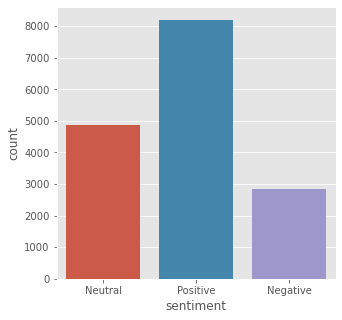

In [75]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = df)


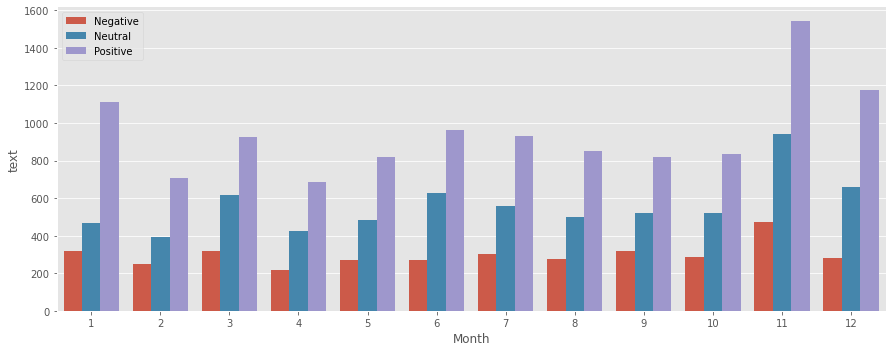

In [64]:
sentiment_month=pd.DataFrame(df.groupby(['Month','sentiment'])['text'].count())
#plt.figure(figsize=(20,5))
sns.catplot(kind='bar',x='Month',
            y='text',hue='sentiment', legend=False, 
            height=5, # make the plot 5 units high
            aspect=2.5,
            data=sentiment_month.reset_index())
plt.legend(loc='upper left')

In [76]:
df2=df.groupby(['Month','sentiment']).agg({'text':'count'})
df3 = df2.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

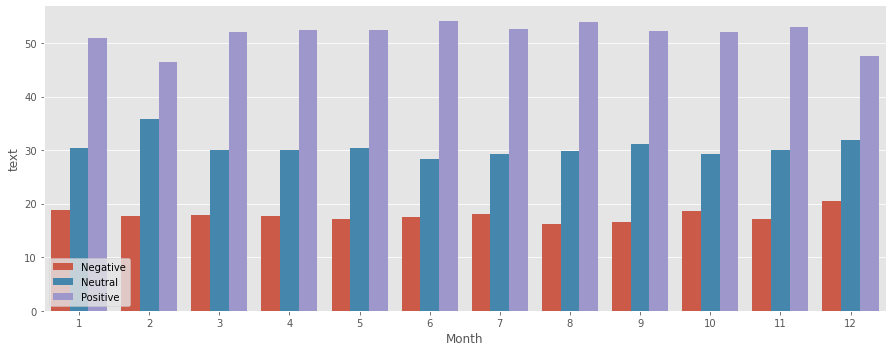

In [77]:
sns.catplot(kind='bar',x='Month',
            y='text',hue='sentiment', legend=False, 
            height=5, # make the plot 5 units high
            aspect=2.5,
            data=df3.reset_index())
plt.legend(loc='lower left')

Text(0.5, 1.0, 'Distribution of sentiments')

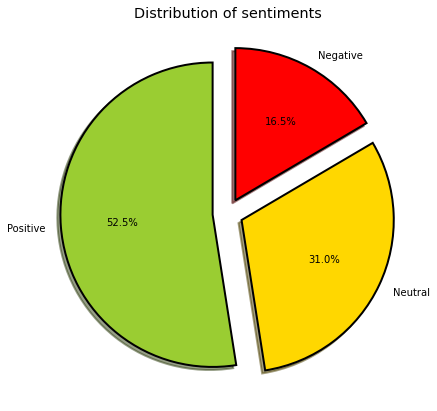

In [16]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [260]:
pos_tweets = df[df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['compound'], ascending= False)
pos_tweets.head(10)
pd.options.display.max_colwidth = 100

In [263]:
pos_tweets.text.head(10)

1859              love actually liked following happily retweeted thanks giving opportunity win great prize
4179                           wow lovely hope lucky thanks chance good luck everyone ive happily retweeted
6877                         would love win amazing prize love baking nice treat child especially christmas
2357                            liked following happily retweeted thanks giving opportunity win great prize
5389    im liking rtampf chance win lovely luxury christmas assortment friday id moon amp around sun amp...
6138    great night yesterday women business 2018 supporting excellent speakers lovely high tea excited ...
5543    win parents theyve high low life supporting throughout kind generous happy giving love without q...
2903    beyond amazing amp super impressed vegangluten free etc option youve offer ive go pescatarian iv...
4947    rtampf chance win ridiculous passion passionfruit id love winner award winning passionfruit gin ...
2400                        

In [264]:
#stop_words.append('aldi_ireland','aldi','aldiuk')
#for word in ['one','get','got','amp','im']:
my_stop_words=['would','shopping','shop','go','going','store','like','one','get','got','amp','im','ive','ill','aldi_ireland','aldi','aldiuk']


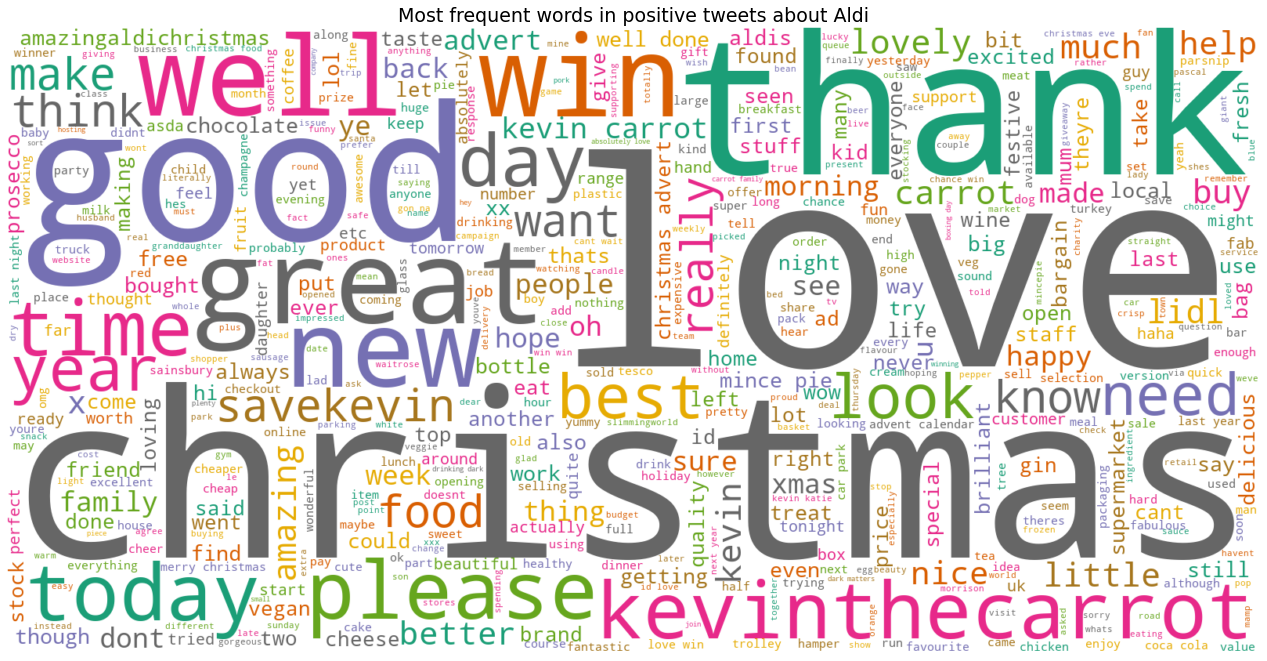

In [269]:
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(background_color='white',
                        colormap='Dark2',
                      stopwords=my_stop_words,
                      max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets about Aldi', fontsize=19)
plt.show()

In [270]:
neg_tweets = df[df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['compound'], ascending= False)
neg_tweets.head(10)

User               Date Created  Number of Likes  \
5264      lyns_wall74  2018-11-18 15:22:40+00:00                0   
726          amypoops  2019-01-19 18:49:54+00:00                1   
2905   PaulGHernandez  2018-12-13 15:05:45+00:00                0   
6939   scotthughesoff  2018-11-02 19:22:03+00:00                0   
6314   BirminghamCats  2018-11-07 17:44:14+00:00                2   
4495     JayneyBarnes  2018-11-23 17:40:47+00:00                0   
6647  JamesCRoberts94  2018-11-04 10:55:49+00:00                0   
3470          boo1003  2018-12-06 21:47:22+00:00                0   
3499        Rumseywoo  2018-12-06 17:52:10+00:00                0   
3585   Kathrynpollard  2018-12-04 23:19:35+00:00                0   

                        Location  \
5264                  merseyside   
726              Yorkshire Dales   
2905              Manchester, UK   
6939              Wrexham, Wales   
6314  Birmingham, United Kingdom   
4495         Widnes, Cheshire UK   
6647       Merthyr Tydfil, Wales   
3470                          uk   
3499           Basildon, England   
3585                        Home   

                                                                                                    Tweet  \
5264            @AldiUK Oooooh I’m so excited 😆 my son and myself can’t wait 😊 thanks for letting me know   
726   @BahaNick16 @AldiUK Wowzers bargain !!! I’ve just been to the Skipton one and never spotted that...   
2905  My poor Mum went and got a tree from @AldiUK in Beighton and after only a few days it shed half ...   
6939                                                @AldiUK @CocaCola HE CANT EVEN REACH THE PEDALS !!!!!   
6314  Dear @AldiUK what are you putting in your catnip toys? The cats of Birmingham are going absolute...   
4495                                                                @AldiUK #kevinthecarrot hysterical 😂😂   
6647  Time to get my battle outfit ready to go shopping at @AldiUK on a Sunday  morning. https://t.co/...   
3470                                                                              @AldiUK Trivial Pursuit   
3499                                                    @AldiUK Monopoly or trivial pursuit\n🤞🏻🥰🤞🏻🥰🤞🏻🥰🤞🏻🥰   
3585  Working in Aldi, taxi driver says this to me. My reply ‘well I’m a fully qualified TA, I’m also ...   

      retweet_count  \
5264              0   
726               0   
2905              0   
6939              0   
6314              0   
4495              0   
6647              0   
3470              0   
3499              0   
3585              0   

                                                                                                     text  \
5264                                                  oooooh im excited son cant wait thanks letting know   
726                                             wowzers bargain ive skipton never spotted bargain enjoy x   
2905  poor mum went tree beighton day shed half needle turned lovely shade poo brown didnt even chance...   
6939                                                                               cant even reach pedals   
6314                 dear putting catnip toys cat birmingham going absolutely crazy especially banana one   
4495                                                                            kevinthecarrot hysterical   
6647                                                  time battle outfit ready go shopping sunday morning   
3470                                                                                      trivial pursuit   
3499                                                                             monopoly trivial pursuit   
3585  working aldi taxi driver say reply well im fully qualified ta im also fully qualified work child...   

                          Date  Month  \
5264 2018-11-18 15:22:40+00:00     11   
726  2019-01-19 18:49:54+00:00      1   
2905 2018-12-13 15:05:45+00:00     12   
6939 2018-11-02 19:22:03+00:00     11   
6

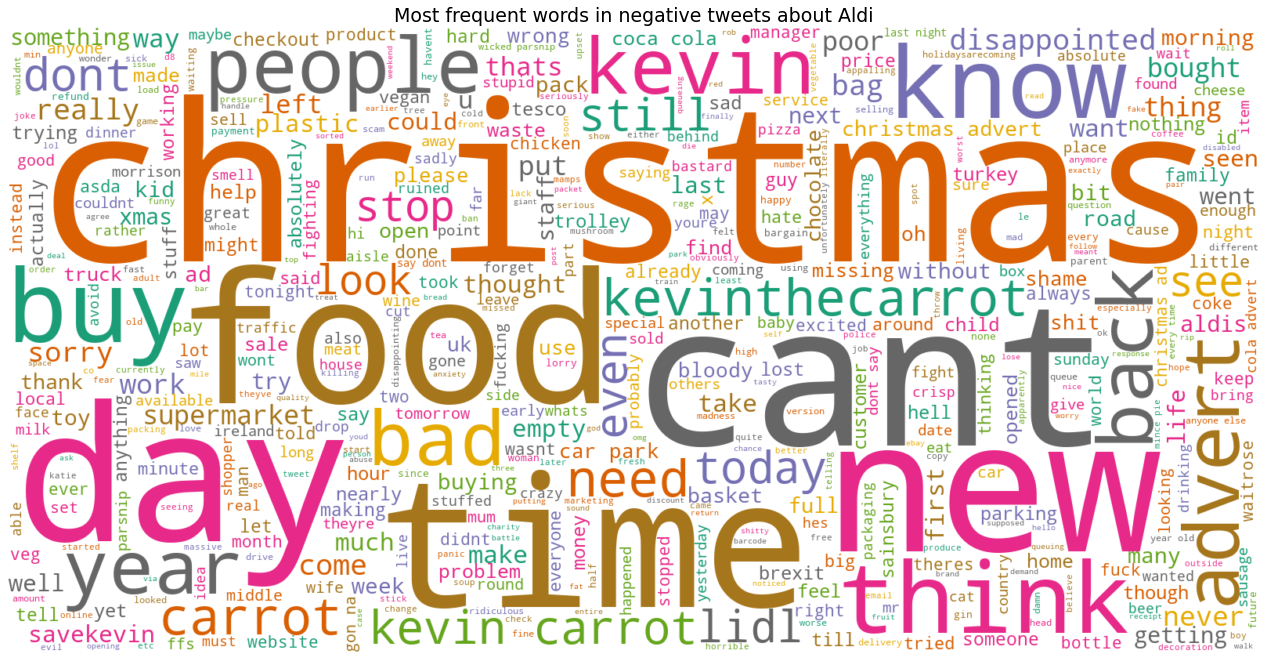

In [272]:
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(background_color='white',
                        colormap='Dark2',
                      stopwords=my_stop_words,
                      max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets about Aldi', fontsize=19)
plt.show()

In [266]:
for i in range(10):
    print(i+1,'.',pos_tweets['text'].iloc[i],"\n")

1 . love actually liked following happily retweeted thanks giving opportunity win great prize 

2 . wow lovely hope lucky thanks chance good luck everyone ive happily retweeted 

3 . would love win amazing prize love baking nice treat child especially christmas 

4 . liked following happily retweeted thanks giving opportunity win great prize 

5 . im liking rtampf chance win lovely luxury christmas assortment friday id moon amp around sun amp straight local aldi store super lucky winner 

6 . great night yesterday women business 2018 supporting excellent speakers lovely high tea excited win raffle networking cwmbran charity ilovealdi 

7 . win parents theyve high low life supporting throughout kind generous happy giving love without question 

8 . beyond amazing amp super impressed vegangluten free etc option youve offer ive go pescatarian ive sle amp loving choice store choose heaven word 

9 . rtampf chance win ridiculous passion passionfruit id love winner award winning passionfruit

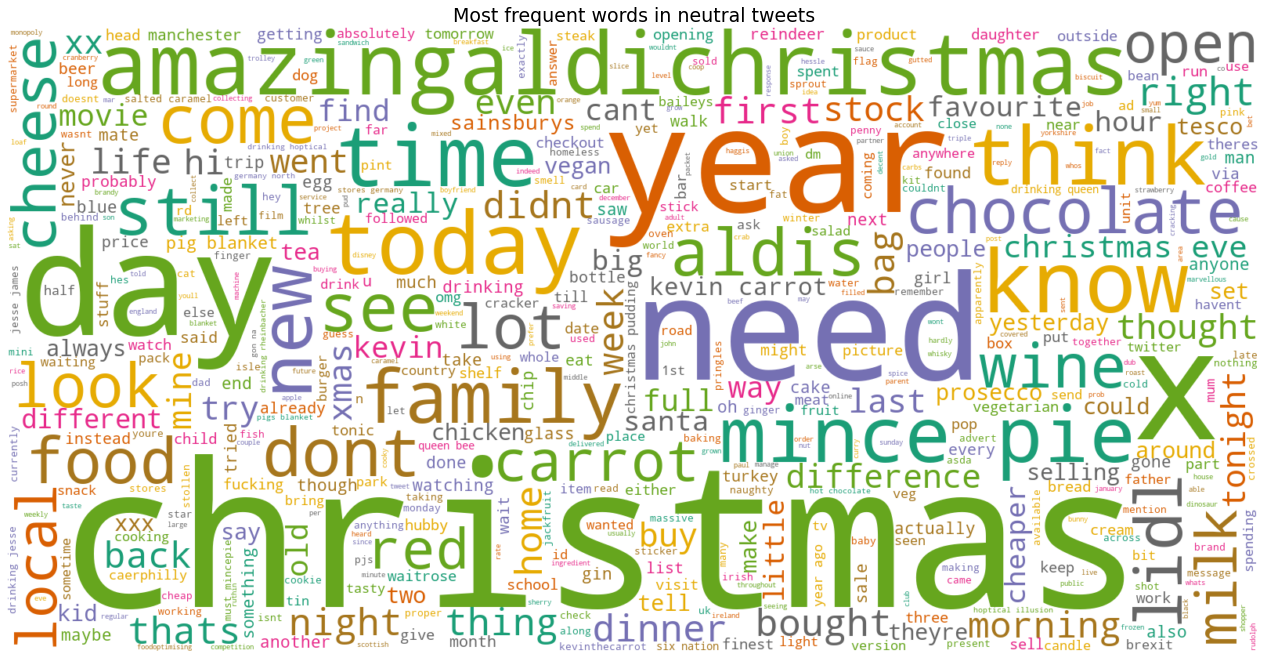

In [714]:
neutral_tweets = text_df[text_df.sentiment == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['compound'], ascending= False)
neutral_tweets.head()
text = ' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(background_color='white',
                        colormap='Dark2',
                      stopwords=my_stop_words,
                      max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

## Morrisons

In [170]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = stopwords.words('english')
custom_stopwords = ('RT', '#morrisons','one','get','got','amp','im','ive','ill')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [130]:
df = pd.read_csv('mor 180101 180701.csv')
print(df.shape)
df=df.iloc[:,1:]

(6623, 7)


In [131]:
df = pd.read_csv('mor 180701 190101.csv')
print(df.shape)
df=df.iloc[:,1:]

(6215, 7)


In [619]:
df = pd.read_csv('mor 190101 190701.csv')
print(df.shape)
df=df.iloc[:,1:]

(8479, 7)


In [623]:
df = pd.read_csv('mor 190701 200101.csv')
print(df.shape)
df=df.iloc[:,1:]

(9276, 7)


In [160]:
df = pd.read_csv('mor 19.csv')
print(df.shape)
df=df.iloc[:,1:]

(11220, 7)


In [174]:
df = pd.read_csv('mor 190801 191101.csv')
print(df.shape)
df=df.iloc[:,1:]

(2422, 7)


In [517]:
df = pd.read_csv('mor 190901 191201.csv')
print(df.shape)
df=df.iloc[:,1:]

(4358, 7)


In [526]:
df['Tweet'] = df['Tweet'].astype("string")

In [173]:
df=df[df['Tweet'].str.contains(rf'morrisons',case=False,regex=True)]
df.info()
df.to_csv('mor 190801 191101.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2422 entries, 1 to 4134
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User             2422 non-null   object
 1   Date Created     2422 non-null   object
 2   Number of Likes  2422 non-null   int64 
 3   Location         2194 non-null   object
 4   Tweet            2422 non-null   object
 5   retweet_count    2422 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 132.5+ KB


In [175]:
df['text'] = df['Tweet'].apply(lambda x: preprocess_tweets(x, custom_stopwords))
df.shape

(2422, 7)

In [176]:
df['Date'] = pd.to_datetime(df['Date Created'])
df['Month'] = df['Date'].dt.month

text_df=df.drop(['User','Date Created','Number of Likes','Location','Tweet','retweet_count'], axis=1)

In [177]:
df.loc[:,'text'] = df['text'].apply(data_processing)
df = df.drop_duplicates('text')

df.loc[:,'text'] = df['text'].apply(lambda x: stemming(x))

df.head(10)

User               Date Created  Number of Likes  \
0         cptpugsy  2019-10-31 23:12:45+00:00                1   
1    PaulineSwales  2019-10-31 20:40:57+00:00                3   
2       SoProJanet  2019-10-31 13:53:41+00:00                4   
3    ChrisQuinnNCL  2019-10-31 13:22:54+00:00                0   
4       Dani021692  2019-10-31 13:10:39+00:00                0   
5     thealmightyG  2019-10-31 12:56:25+00:00                0   
6     BradleyHorne  2019-10-30 20:18:23+00:00                4   
7  SolicitingFlava  2019-10-30 20:18:17+00:00                3   
8      TheWineKiwi  2019-10-30 20:17:23+00:00               24   
9            Nee69  2019-10-30 18:35:54+00:00                0   

                       Location  \
0          dni if ur underage 😡   
1                           NaN   
2                  Huddersfield   
3  Newcastle Upon Tyne, England   
4                           NaN   
5         The Vale of GazMorgan   
6            Teddington, London   
7                       Cardiff   
8      Scotland, United Kingdom   
9      Liverpool, Great Britain   

                                               Tweet  retweet_count  \
0                                morrisons be like H              0   
1  Thank you to everyone who supported our tombol...              1   
2  Our long standing association with #cake has s...              0   
3  Appalling packaging inside this from @Morrison...              1   
4  Jeez nearly threw up in Morrisons because of a...              0   
5  @MrFilmFan @Tesco @asda @Morrisons @marksandsp...              0   
6  @TheWineKiwi @timntweet @Morrisons @BodegasLus...              0   
7  @TheWineKiwi @timntweet @Morrisons @BodegasLus...              0   
8  Thanks to @timntweet for the heads up that @Mo...              4   
9  Wow, great sausages!!! 🔥🔥 Upped them up with C...              0   

                                                text  \
0                                    morrison like h   
1  thank everyone supported tombola today raised ...   
2  long standing association cake served well tha...   
3  appalling packaging inside unfortunately could...   
4  jeez nearly threw morrisons overwhelming smell...   
5  people away thinking privilege parking road fr...   
6                              thanks head find near   
7                                        cheers head   
8  thanks head moscatel emilin reduced 8 12 btl f...   
9  wow great sausages upped chilli english mustar...   

                       Date  Month  
0 2019-10-31 23:12:45+00:00     10  
1 2019-10-31 20:40:57+00:00     10  
2 2019-10-31 13:53:41+00:00     10  
3 2019-10-31 13:22:54+00:00     10  
4 2019-10-31 13:10:39+00:00     10  
5 2019-10-31 12:56:25+00:00     10  
6 2019-10-30 20:18:23+00:00     10  
7 2019-10-30 20:18:17+00:00     10  
8 2019-10-30 20:17:23+00:00     10  
9 2019-10-30 18:35:54+00:00     10

In [178]:
df['scores']=df['text'].apply(lambda text: sid.polarity_scores(text))
df['compound']=df['scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment'] = df['compound'].apply(sentiment)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2421
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   User             2328 non-null   object             
 1   Date Created     2328 non-null   object             
 2   Number of Likes  2328 non-null   int64              
 3   Location         2108 non-null   object             
 4   Tweet            2328 non-null   object             
 5   retweet_count    2328 non-null   int64              
 6   text             2328 non-null   object             
 7   Date             2328 non-null   datetime64[ns, UTC]
 8   Month            2328 non-null   int64              
 9   scores           2328 non-null   object             
 10  compound         2328 non-null   float64            
 11  sentiment        2328 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(7)
memory usage: 236

In [179]:
df.sentiment.value_counts()

Positive    1197
Neutral      636
Negative     495
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

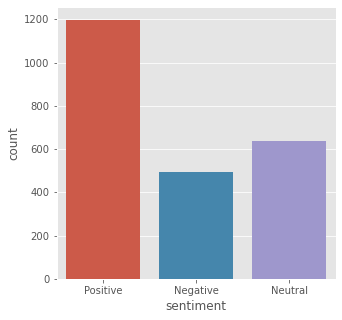

In [180]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = df)


In [181]:
df2=df.groupby(['Month','sentiment']).agg({'text':'count'})
df3 = df2.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

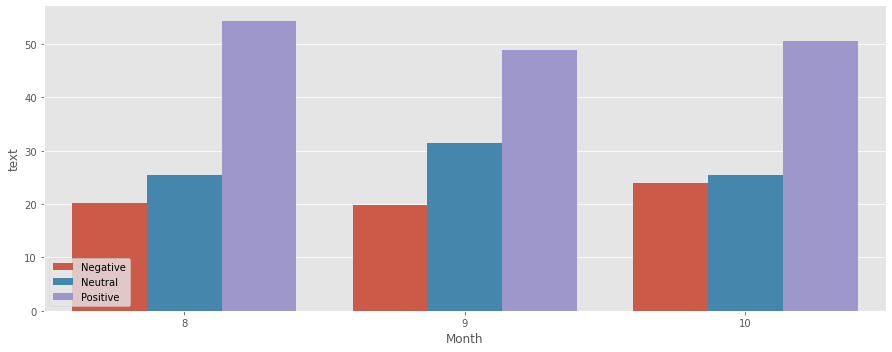

In [182]:
sns.catplot(kind='bar',x='Month',
            y='text',hue='sentiment', legend=False, 
            height=5, # make the plot 5 units high
            aspect=2.5,
            data=df3.reset_index())
plt.legend(loc='lower left')

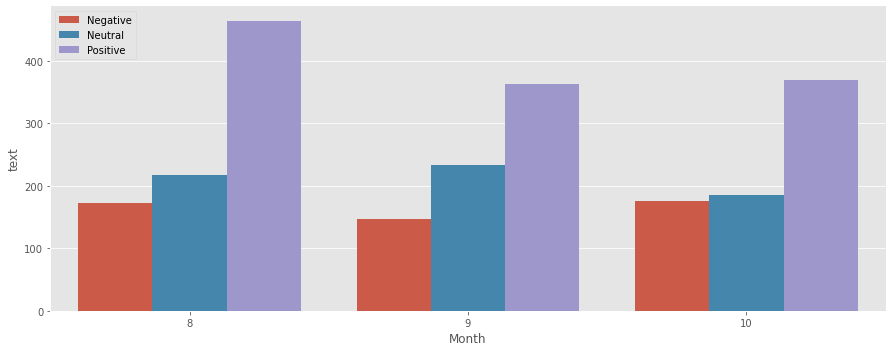

In [183]:
sentiment_month=pd.DataFrame(df.groupby(['Month','sentiment'])['text'].count())
#plt.figure(figsize=(20,5))
sns.catplot(kind='bar',x='Month',
            y='text',hue='sentiment', legend=False, 
            height=5, # make the plot 5 units high
            aspect=2.5,
            data=sentiment_month.reset_index())
plt.legend(loc='upper left')

Text(0.5, 1.0, 'Distribution of sentiments')

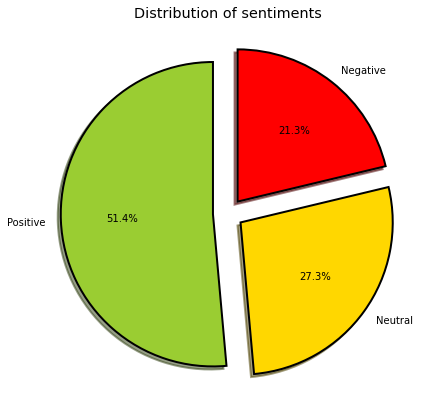

In [184]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [142]:
#stop_words.append('aldi_ireland','aldi','aldiuk')
#for word in ['one','get','got','amp','im']:
my_stop_words=['would','ive','going','go','like','store','shop','shopping','morrison','morrisons','one','get','got','amp','im','ill']


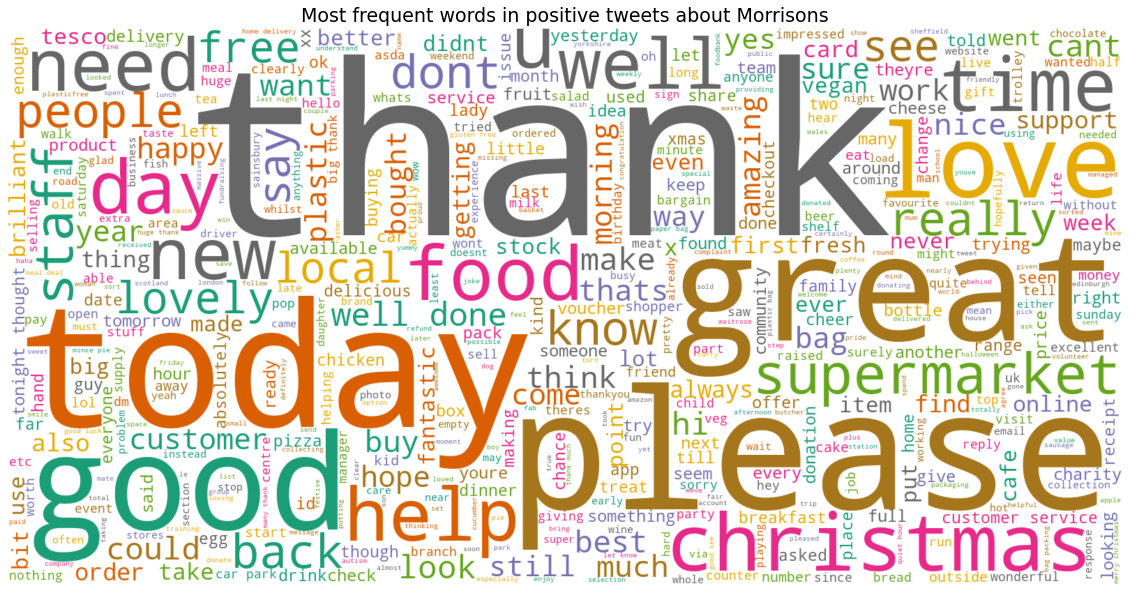

In [143]:
pos_tweets = df[df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['compound'], ascending= False)
pos_tweets.head()
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(background_color='white',
                        colormap='Dark2',
                      stopwords=my_stop_words,
                      max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets about Morrisons', fontsize=19)
plt.show()

In [144]:
neg_tweets = df[df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['compound'], ascending= False)

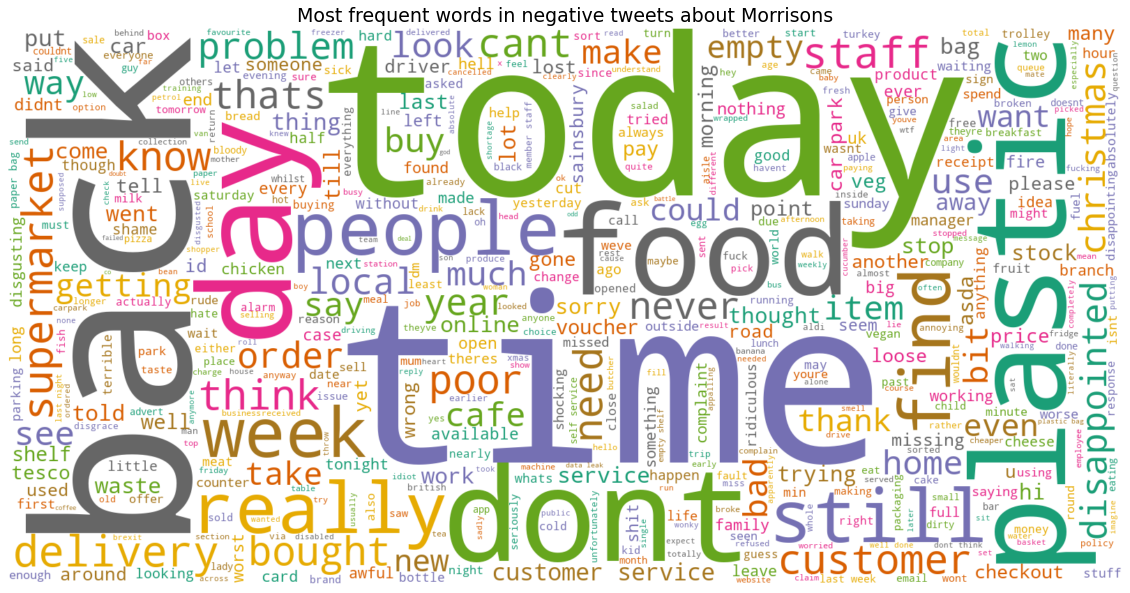

In [145]:
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(background_color='white',
                        colormap='Dark2',
                      stopwords=my_stop_words,
                      max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets about Morrisons', fontsize=19)
plt.show()

In [148]:
for i in range(10):
    print(i+1,'.',pos_tweets['text'].iloc[i],"\n")


1 . guy anything like customer service award please consider delivery driver sean nash enfield far cheerful helpful friendly delivery remember great advert company cheered weekend top man 

2 . bar perfect lunch box dont add cane sugar deliciously fruity bars thank entering comp great tweet good luck hope amazing bankholidayweekend 

3 . huge thanks welcoming staff generous customer lindsayfield east kilbride super time bagpacking thanks much opportunity raise vital fund brave young patient 

4 . yes danai community champ stamfordhill shes absolutely brilliant enthusiasm amp passion helping community utterly inspiring amp infectious donation box store far successful c100150 packet period product month 

5 . lovely hear son love bars special offer moment waitroes ocado thank entering giveaway best luck winning 

6 . kiddies love extra fruity tasting bars thank entering comp great tweet good luck hope amazing bankholidayweekend 

7 . fabulous hope family well enjoying sunshine getting re

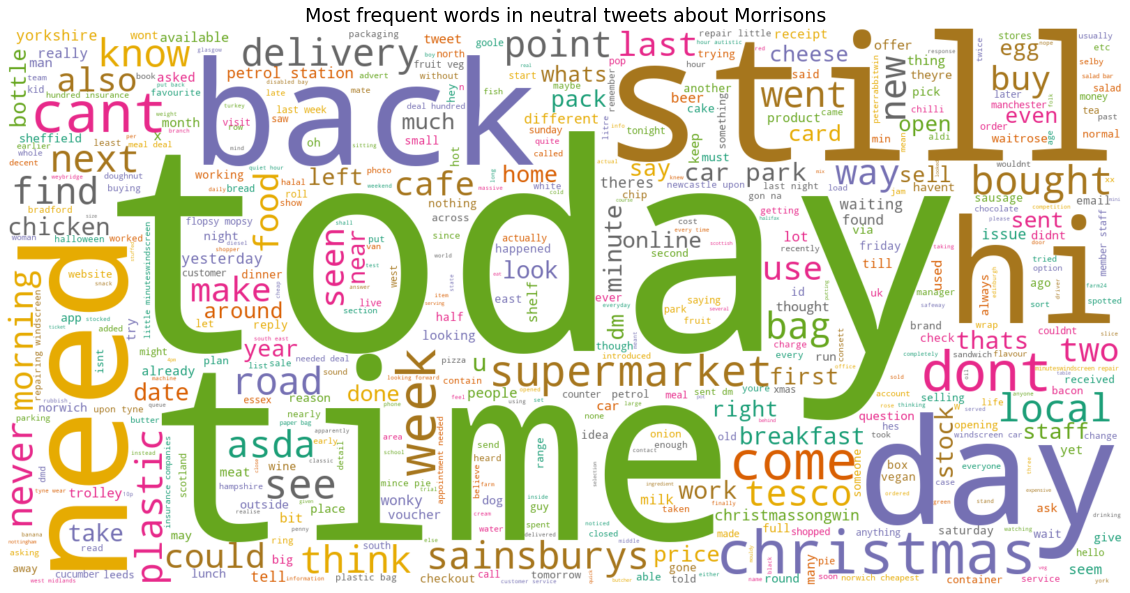

In [147]:
neutral_tweets = df[df.sentiment == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['compound'], ascending= False)
neutral_tweets.head()
text = ' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(background_color='white',
                        colormap='Dark2',
                      stopwords=my_stop_words,
                      max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets about Morrisons', fontsize=19)
plt.show()